In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import argparse
from tqdm.notebook import tqdm
from itertools import product
from collections import Counter
from tqdm import tqdm

# parser = argparse.ArgumentParser(description='Toy model BM')
# parser.add_argument('-N',type=int, default=1000, help='Size of the dataset')
# parser.add_argument('-S',type=int, default=10, help="Amount of spins")
# args = parser.parse_args()


def unnormalized_p(s, w,theta):
    return np.exp(0.5*np.dot(s,np.dot(w,s)) + np.dot(theta, s))


def p_s_w(s, w, theta, Z):
    # for the exact model needs to be calculated exactly, thus including the normalization constant.
    return 1/Z * unnormalized_p(s, w, theta)


def likelihood(w,theta,data, Z):
    nom = [unnormalized_p(s,w,theta) for s in data] 
    return np.mean(nom, axis=0) - np.log(Z)


def clamped_statistics(data, batch_size=1000):
    print("generate clamped statistics")
    single = 1/(len(data)) * np.sum(data, axis=0)

    outer_sum = np.zeros((data.shape[1], data.shape[1]))
    for i in tqdm(range(0, len(data), batch_size)):
        outer_sum += np.sum([np.outer(x, x) for x in data[i:i+batch_size]], axis=0)
    double = 1/(len(data)) * outer_sum

    # Diagonals are set to zero. 
    # Since the diagonal of the w should be zero anyway.
    np.fill_diagonal(double, 0.)
    return single, double


def direct_solve(data, eps, clamped_single, clamped_double):
    C = clamped_double - np.outer(clamped_single, clamped_single)
    C = C + np.eye(*C.shape)*eps
    m = clamped_single

    w = np.zeros_like(C)
    np.fill_diagonal(w, 1/(1-m**2))
    w = w - np.linalg.inv(C)
    # return np.mean(w)

    theta = np.arctanh(m) - np.dot(w, m)

    Z = np.sum([unnormalized_p(s,w,theta) for s in data])
    return np.exp(likelihood(w, theta, data, Z))

In [3]:
data = np.loadtxt("bint.txt")
# data = data[np.random.choice(range(160), size=10, replace=False)]
data = data.transpose()
clamped_single, clamped_double = clamped_statistics(data)
print("data retreived")

generate clamped statistics


100%|██████████| 284/284 [00:26<00:00, 10.76it/s]

data retreived


In [ ]:
for x in [0.005, 0.03, 0.05,  0.1, :
    print(f"{x}: {direct_solve(data, x, clamped_single, clamped_double)}" )

0.005: -8.073093989808688
0.03: -0.07691432709417807
0.05: -0.08442241843189631
0.1: -0.032101779376977155
1: 0.0009456065827273109


In [5]:
# seed to make sure it can be recreated
# np.random.seed(42)
# indices_10 = np.random.choice(range(160), size = args.N, replace = False)
# data = data_before[indices_10]

# Create toy model dataset
# data = np.array([np.random.randint(0, 2, size=args.S) for _ in range(args.N)])
epss = [x for x in np.linspace(0.03, 0.5, 20)]
result = [direct_solve(data, eps, clamped_single, clamped_double) for eps in tqdm(epss)]

/var/folders/s9/fggsb3jn2kv14qg5vd8bn2km0000gn/T/ipykernel_7693/384257966.py:57: RuntimeWarning: overflow encountered in exp
  return np.exp(likelihood(w, theta, data, Z))
100%|██████████| 20/20 [04:59<00:00, 14.97s/it]


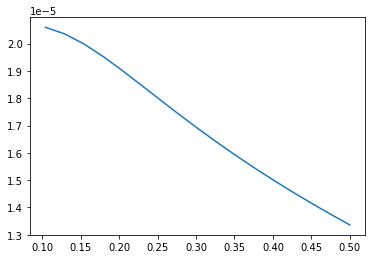

In [7]:
plt.plot(epss, result)
# plt.yscale('log')
plt.show()